<a href="https://colab.research.google.com/github/GitBar20/AI/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22varfarin_2023_augmented_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Парсинг данных - выделение по группам (оставлен код исходного парсера)
* возрастов
* диагнозов
* вычисление относительной даты анализа

In [ ]:
# В файл ЦАТ_общий_parsed_extDS_v6.xlsx относительно ЦАТ_общий_parsed.xlsx
# добавлены:
# institution_id - id лечебного учреждения (на основании первого столбца с названием)
# diagnos и sss - записи о диагнозе и сердечно-сосудистых событиях из первичных файлов

# Группы диагнозов: обрабатываются поля диагнозов и сердечно-сосудистых событий
# d1 - Протезирование клапанов
# d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
# d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
# d4 - (I05-09)Ревматическая болезнь сердца
# d5 - (I35)Неревматические поражения аортального клапана
# d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
# d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
# d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)

# Группы возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

# Относительная давность анализа:
# date_from_1990 = количество дней от 01.01.1990 до date_analyse



In [ ]:
# устанавливаем phik - в коллабе по умолчанию его у меня нет

!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from datetime import datetime
import phik
from phik import resources, report

In [ ]:
# загружаем в colab Копия ЦАТ_общий_parsed_extDS_v6.xlsx
gdown.download('https://drive.google.com/uc?export=download&id=1ZdF0dESb9BIzj7yp75IM3GIJeDO7cyVg', quiet=True, fuzzy=True)

#загружем Копия ЦАТ_общий_parsed_extDS_v6.xlsx в dataframe pandas
df = pd.read_excel('/content/Копия ЦАТ_общий_parsed_extDS_v6.xlsx', decimal=",")
df.head()

,institution,id,gender,age,dose,date_analyse,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,institution_id,diagnos,sss
0,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.50,2022-11-11,3.11,1,0,0,13.0,3.32,1,0,20,Фибрилляция предсердий,NaN
1,ГБУЗ РБ Толбазинская ЦРБ,140361892057136,0,57,7.50,2022-11-24,3.32,1,0,0,15.0,2.01,2,0,20,Фибрилляция предсердий,NaN
2,ГБУЗ РБ Толбазинская ЦРБ,140361892057264,1,50,5.00,2022-11-22,2.01,0,1,0,26.0,2.75,1,0,20,ПротезированиеМитрального клапана,NaN
3,ГБУЗ РБ Толбазинская ЦРБ,140361892057392,0,53,6.25,2022-11-21,1.42,1,0,0,15.0,2.56,1,0,20,Фибрилляция предсердий,NaN
4,ГБУЗ РБ Толбазинская ЦРБ,140361892057392,0,53,6.25,2022-12-06,2.56,1,0,0,49.0,2.80,2,0,20,Фибрилляция предсердий,NaN


In [ ]:
# создаем копию датафрейма
data = df.copy()

## Функции для формирования доп.колонок (код сохранен без изменений исходного парсера).
Создаются новые столбцы по группам возрастов, по группам заболеваний и столбец с относительной давностью анализа:  date_from_1990

In [ ]:
# Сформируем колонки по группам возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

def get_level(x):
# age_level	0-10-30-50-60-70-80-90+
    if x < 10 : return 0
    if x >= 10 and x < 30 : return 10
    if x >= 30 and x < 50 : return 30
    if x >= 50 and x < 60 : return 50
    if x >= 60 and x < 70 : return 60
    if x >= 70 and x < 80 : return 70
    if x >= 80 and x < 90 : return 80
    return 90

def get_level1(x):
# age_level1	0-50-65-75-80+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 80 : return 75
    return 80

def get_level2(x):
# age_level2	0-35-50-65-80+
    if x < 35 : return 0
    if x >= 35 and x < 50 : return 35
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level3(x):
# age_level3	0-50-65-75-90+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 75 : return 65
    if x >= 75 and x < 90 : return 75
    return 90

def get_level4(x):
# age_level4	0-50-65-80
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    if x >= 65 and x < 80 : return 65
    return 80

def get_level5(x):
# age_level5	0-50-65+
    if x < 50 : return 0
    if x >= 50 and x < 65 : return 50
    return 65

In [ ]:
# поисковые конструкции для diagnos и sss
# for d1 -диагноз или ссс содержат слово "проте"
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
# for d5-  I35,i35
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
# for d7 - аорт, митр,клап,перегор
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац

def get_d1(x):
  # for d1 -диагноз или ссс содержат слово "проте"
  wlist = ['проте']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d2(x):
# for d2- фибр, фебр,ФП,трепет,i48,I48,I 48
  wlist = ['фибр', 'фебр','ФП','трепет','i48','I48','I 48']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d3(x):
# for d3- порок,ИБС,склероз,ОИМ,инфаркт,миокард,стенокар,I20,I25,ПИКС,пикс,ишемич,кард,ВПС,ОКС,стенокардия,ТИА,эндокардит,порок
  wlist = ['порок','ИБС','склероз','ОИМ','инфаркт','миокард','стенокар','I20',
           'I25','ПИКС','пикс','ишемич','кард','ВПС','ОКС','стенокард',
           'ТИА','эндокардит','порок']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d4(x):
# for d4-  I 08,I05,i05,i08,I06,I09,ревмат,
  wlist = ['I 08','I05','i05','i08','I06','I09','ревмат']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d5(x):
# for d5-  I35,i35
  wlist = ['I35','i35']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d6(x):
# for d6 - ДКМП, I42, ОНМК,i34,Q231,ГБ,легочн,ТЭЛА
  wlist = ['ДКМП', 'I42', 'ОНМК','i34','Q231','ГБ','легочн','ТЭЛА']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d7(x):
# for d7 - аорт, митр,клап,перегор
  wlist = ['аорт', 'митр','клап','перегор']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

def get_d8(x):
# for d8 - АКШ,МКШ,шунт,стент,ЭКС,РЧА,аблац
  wlist = ['АКШ','МКШ','шунт','стент','ЭКС','РЧА','аблац']
  for w in wlist:
    w = w.upper()
    if x['diagnos'].upper().find(w) > -1: return 1
    if x['sss'].upper().find(w) > -1: return 1
  return 0

In [ ]:
# Вычисли относительную давность анализа:
# сформируем колонку date_from_1990 = количество дней от 01.01.1990 до date_analyse
date_01011990 = datetime(1990, 1, 1)

data['date_from_1990'] = (data['date_analyse']-date_01011990).dt.days

KeyError: ignored

In [ ]:
# Сформируем колонки по группам возрастов: на основе поля возраст
# age_level	0-10-30-50-60-70-80-90+
# age_level1	0-50-65-75-80+
# age_level2	0-35-50-65-80+
# age_level3	0-50-65-75-90+
# age_level4	0-50-65-80
# age_level5	0-50-65+
# age_level6	0-65+

data['age_level'] = data['age'].apply(get_level)
data['age_level1'] = data['age'].apply(get_level1)
data['age_level2'] = data['age'].apply(get_level2)
data['age_level3'] = data['age'].apply(get_level3)
data['age_level4'] = data['age'].apply(get_level4)
data['age_level5'] = data['age'].apply(get_level5)
data['age_level6'] = np.where((data.age>=65), 65, 0)

In [ ]:
# Сформируем колонки по диагнозам и ССС: на основе колонок diagnos,sss
# d1 - Протезирование клапанов
# d2 - (I48)Фибрилляция и трепетание предсердий, мерцательная аритмия
# d3 - (I20-25)Ишемическая болезнь сердца(ИБС), инфаркт миокарда(ИМ,ОИМ), Хроническая ишемическая болезнь сердца, Постинфарктный крдиосклероз(ПИКС),Врождённый порок сердца(ВПС), эндокардит,острый коронарный синдром(ОКС),транзиторная ишемическая атака(ТИА), порок
# d4 - (I05-09)Ревматическая болезнь сердца
# d5 - (I35)Неревматические поражения аортального клапана
# d6 - (I__)Другие не сердечные заболевания, гипертония(ГБ), тромбофлебит, острое нарушение мозгового кровообращения,ОНМК,тромбоэмболия лёгочной артерии(ТЭЛА)
# d7 - аортальный, митральный порок сердца, поражение клапанов, недостаточность, межсердные перегородки
# d8 - Стентирование сосудов, биопластика(БАП), радиочастотеая катетерная абляция(РЧА),аблация,электростимуляторы(ЭКС),Шунтирование(АКШ,МКШ)



In [ ]:
# приводим к типу 'str'
data['diagnos'] = data['diagnos'].astype( str )
data['sss'] = data['sss'].astype( str )

In [ ]:
data['d1'] = data.apply(lambda x: get_d1(x), axis=1)
data['d2'] = data.apply(lambda x: get_d2(x), axis=1)
data['d3'] = data.apply(lambda x: get_d3(x), axis=1)
data['d4'] = data.apply(lambda x: get_d4(x), axis=1)
data['d5'] = data.apply(lambda x: get_d5(x), axis=1)
data['d6'] = data.apply(lambda x: get_d6(x), axis=1)
data['d7'] = data.apply(lambda x: get_d7(x), axis=1)
data['d8'] = data.apply(lambda x: get_d8(x), axis=1)

In [ ]:
data

# Расчет статистических метрик по столбцу age. Анализ распределения возраста пациентов

In [ ]:
# удаляем явные ошибки из датасета: возраст 0 и больше 100

data = data.drop(data[(data['age'] == 0) | (data['age'] > 100)].index)

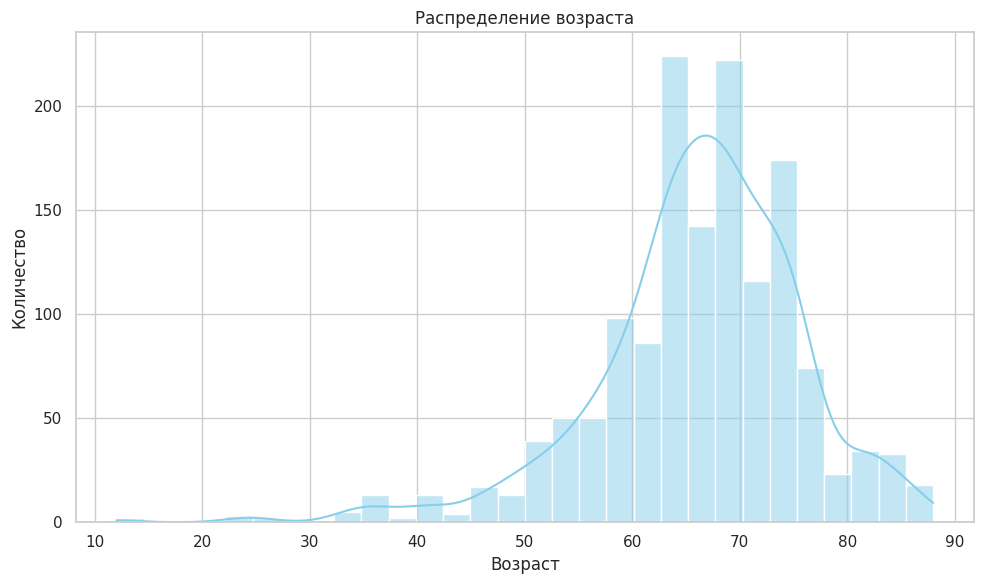

In [ ]:
# Белый фон с сеткой
sns.set_style("whitegrid")

# Гистограмма распределения возраста (столбец 'age')
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=30, kde=True, color="skyblue")
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.tight_layout()

plt.show()




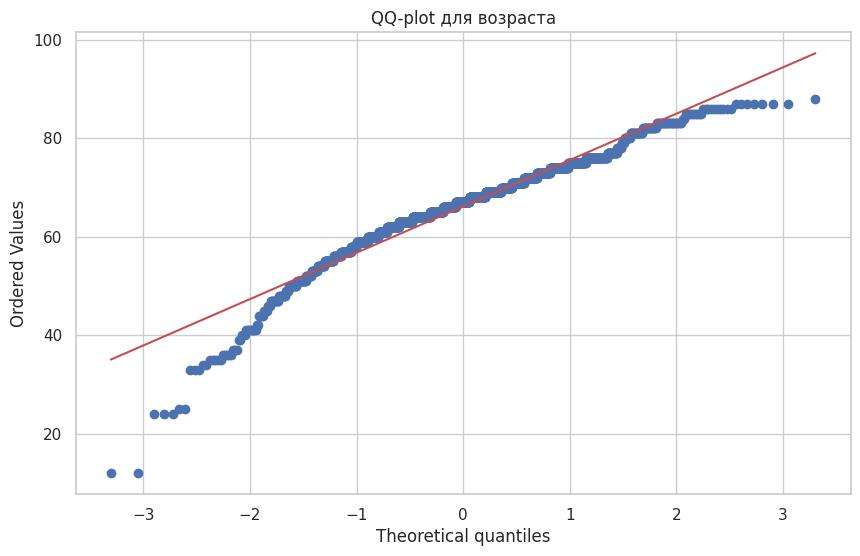

In [ ]:

# QQ-plot - это графический инструмент, который помогает определить, насколько близки данные к некоторому теоретическому распределению,
# чаще всего к нормальному. Если распределение идеально совпадает с нормальным, то точки на QQ-plot будут следовать прямой линии (45-градусной)

import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(data['age'], plot=plt)
plt.title('QQ-plot для возраста')
plt.show()


In [ ]:
# Тест Андерсона-Дарлинга

result = stats.anderson(data['age'])

print(f"Anderson-Darling Test: Statistic={result.statistic}")
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

Anderson-Darling Test: Statistic=15.66016396291252
Critical values: [0.574 0.654 0.785 0.915 1.089]
Significance levels: [15.  10.   5.   2.5  1. ]


Результат тестов показывает, что что распределение данных в столбце 'age' не следует нормальному распределению. Прямое применение стандартных методов машинного обучения может не давать оптимальных результатов, так как большинство методов предполагает, что признаки имеют некое стандартное или нормальное распределение. Но есть модели, устойчивые к несбалансированным данным: модели на основе деревьев хорошо работают с такими данными.

Для дальнейшей оценки кореляции и принятия решения о включении в датасет на базе занных о возрасте рассчитываются следующие статистические показатели  (можно использовать другие):

deviation_from_median: Отклонение возраста от медианного значения возраста в датасете. Если значение положительное, возраст выше медианы; если отрицательное — ниже медианы.

age_percentile: Процентное положение возраста относительно всех остальных возрастов в наборе данных. Он показывает, сколько процентов людей в датасете имеют возраст ниже данного значения.

age_quantile: Показатель делит возраста на четыре равные части (квартили). При этом значение 1 соответствует самому нижнему квартилю (25% самых молодых), а 4 — самому верхнему квартилю (25% самых старых).

is_elderly: Бинарный параметр показывает, превышает ли возраст заданный порог. Если да, то значение равно 1, в противном случае — 0.

age_density: Оценка плотности вероятности для каждого возраста в датасете показывает, насколько "обычным" или "редким" является определенный возраст среди всех возрастов в датасете.

age_zscore: Z-оценка для возраста показывает, на сколько стандартных отклонений конкретное значение возраста отклоняется от среднего значения возраста в ндатасете. Если Z-оценка положительна, возраст выше среднего, и наоборот.

In [ ]:

data['deviation_from_median'] = data['age'] - data['age'].median()
data['deviation_from_median']

0      -10.0
1      -10.0
2      -17.0
3      -14.0
4      -14.0
        ... 
1463     1.0
1464   -32.0
1465   -32.0
1466    -3.0
1467    -3.0
Name: deviation_from_median, Length: 1457, dtype: float64

In [ ]:

data['age_percentile'] = data['age'].apply(lambda x: stats.percentileofscore(data['age'], x))
data['age_percentile']

0       13.658202
1       13.658202
2        5.525051
3        8.201784
4        8.201784
          ...    
1463    55.387783
1464     1.029513
1465     1.029513
1466    34.831846
1467    34.831846
Name: age_percentile, Length: 1457, dtype: float64

In [ ]:
data['age_quantile'] = pd.qcut(data['age'], q=4, labels=[1, 2, 3, 4])
data['age_quantile']

0       1
1       1
2       1
3       1
4       1
       ..
1463    3
1464    1
1465    1
1466    2
1467    2
Name: age_quantile, Length: 1457, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [ ]:
threshold = 70
data['is_elderly'] = (data['age'] > threshold).astype(int)
data['is_elderly']

0       0
1       0
2       0
3       0
4       0
       ..
1463    0
1464    0
1465    0
1466    0
1467    0
Name: is_elderly, Length: 1457, dtype: int64

In [ ]:
data['age_density'] = data['age'].apply(lambda x: float(stats.gaussian_kde(data['age'])(x)))
data['age_density']

0       0.017912
1       0.017912
2       0.007271
3       0.010533
4       0.010533
          ...   
1463    0.049559
1464    0.001983
1465    0.001983
1466    0.045676
1467    0.045676
Name: age_density, Length: 1457, dtype: float64

In [ ]:
mean_age = data['age'].mean() #средний возраст
std_age = data['age'].std() # стандартное отклонение
data['age_zscore'] = (data['age'] - mean_age) / std_age

data['age_zscore']

0      -0.948458
1      -0.948458
2      -1.673105
3      -1.362542
4      -1.362542
          ...   
1463    0.190274
1464   -3.225922
1465   -3.225922
1466   -0.223810
1467   -0.223810
Name: age_zscore, Length: 1457, dtype: float64

# Сохранение расширенного датасета

In [ ]:
# сохраним датасет со всеми новыми столбцами в виртульное окружение - при необходимости сохраните на локальный диск вручную
data.to_excel('dataset_wide.xlsx', index=False)

# Корреляция признаков

In [ ]:
# Удаляем столбцы которые, не влияют на дозу варфарина или переведены в иные числовые параметры
data.drop(['institution', 'institution_id','date_analyse', 'diagnos', 'sss'], axis=1, inplace=True)


<Axes: >

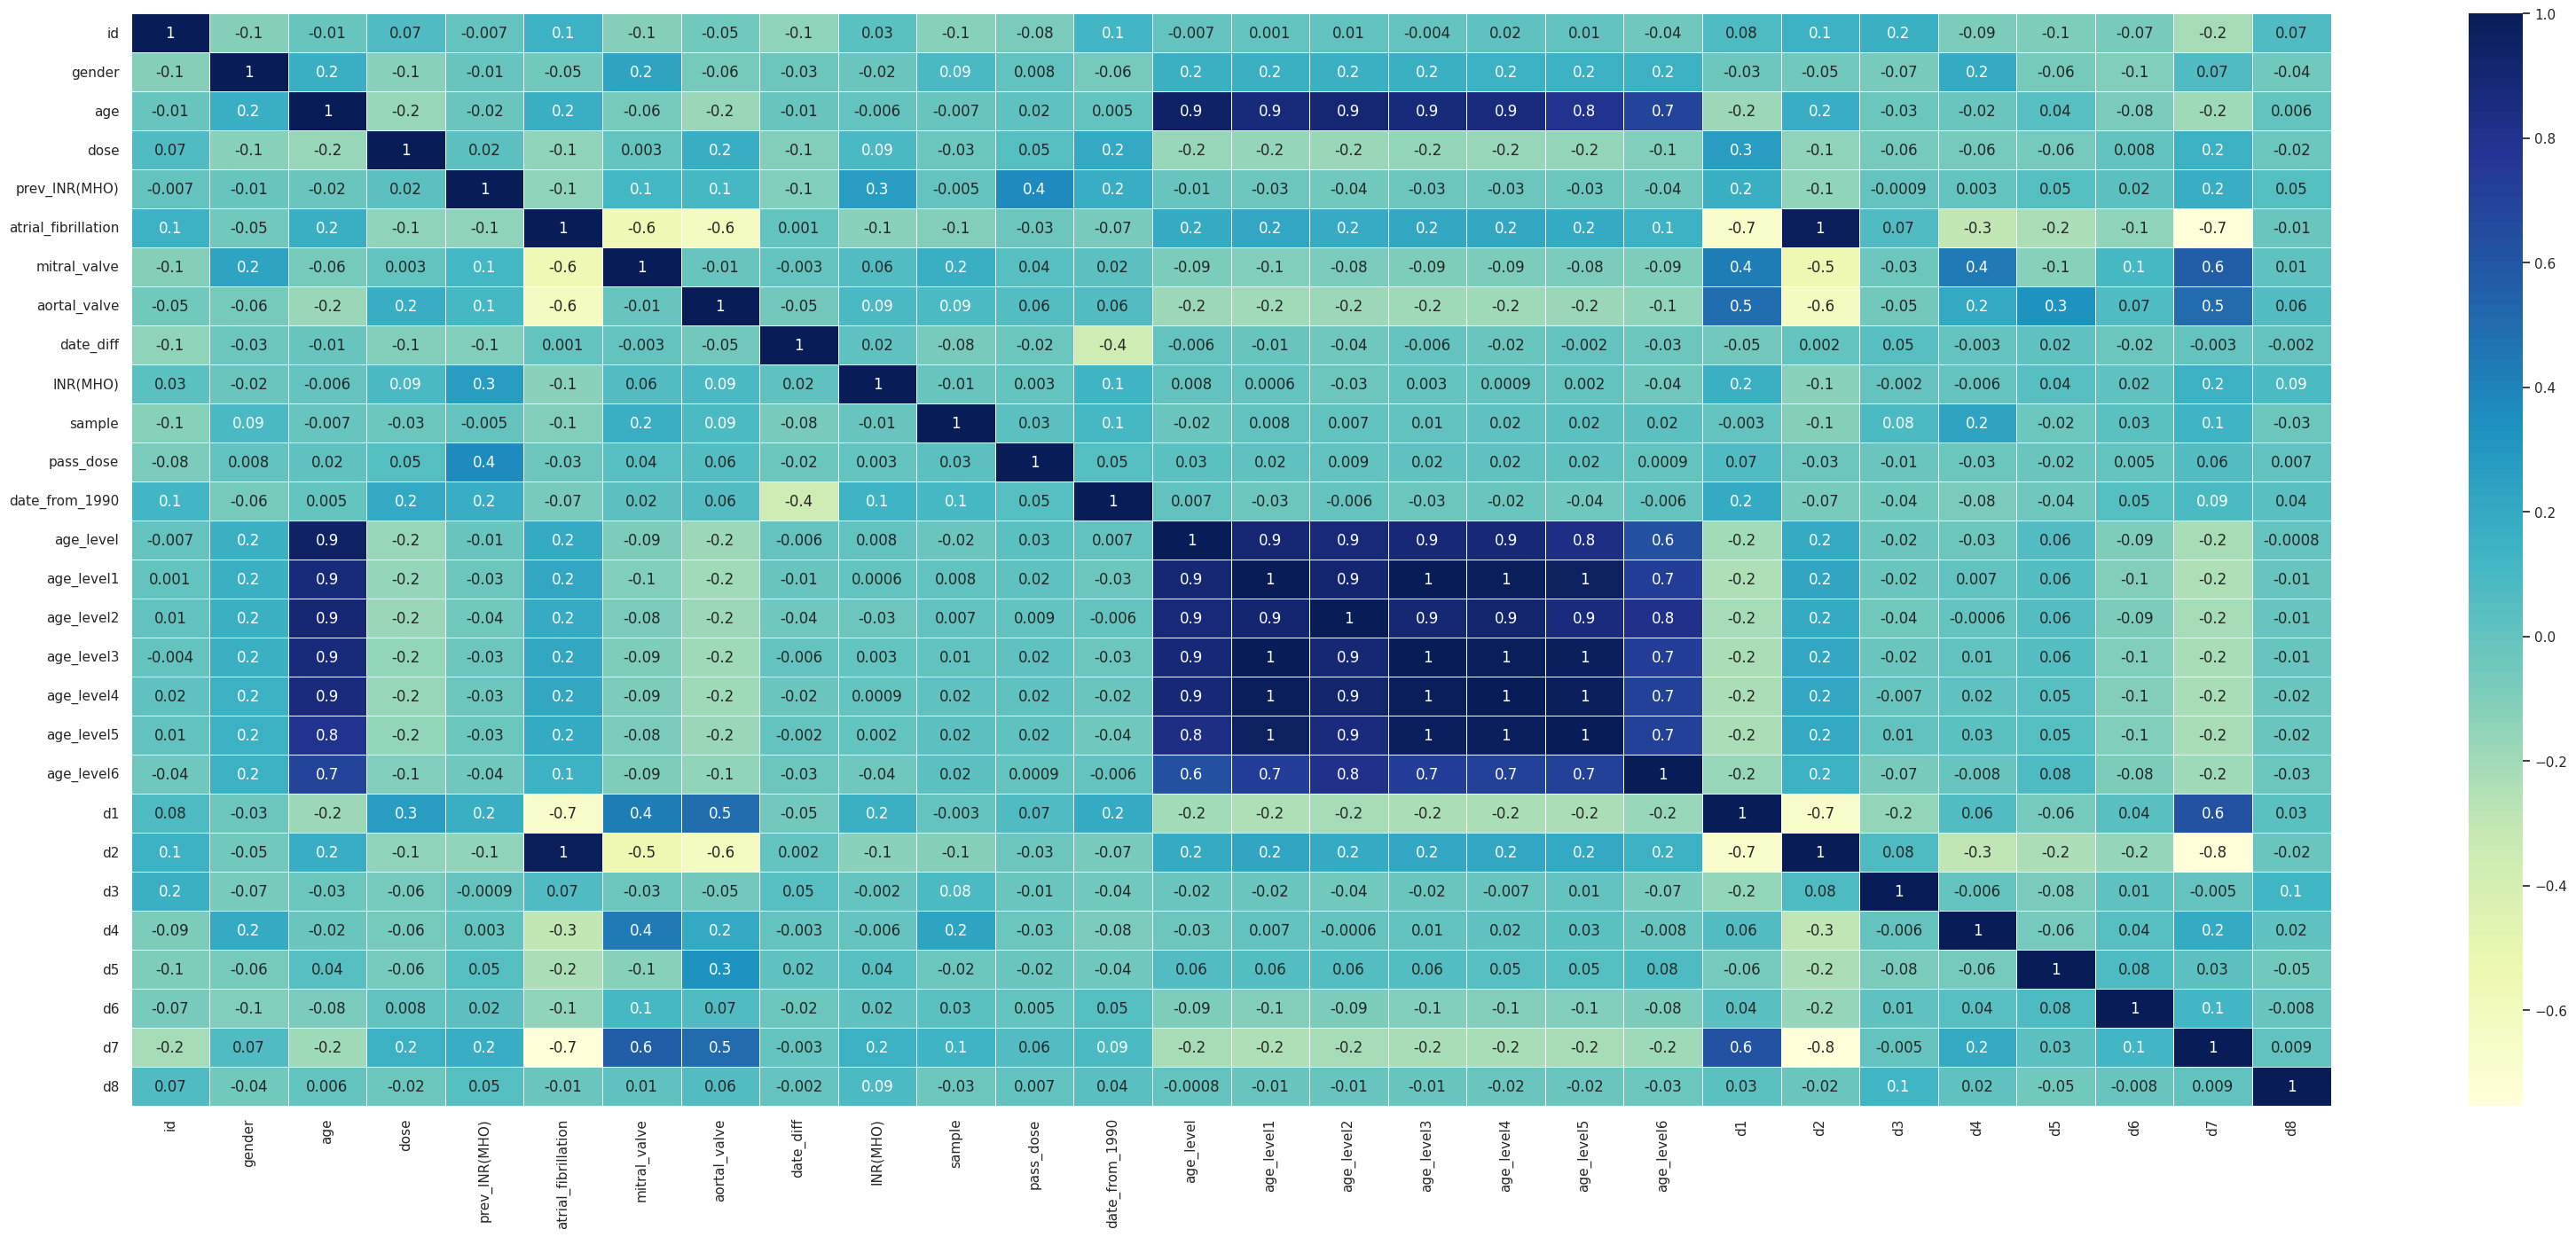

In [ ]:
# тепловая карта на базе корреляции Пирсона - она для текущего датафрейма не показательна,
# поскольку в нем разный тип переменных - и категориальные и интервальные и относительные
sns.set(rc = {'figure.figsize':(40,16)})
#matrix = np.triu(data.corr())
sns.heatmap(data.corr(), linewidths=.5, annot=True, cmap='YlGnBu', fmt='.1g')

interval columns not set, guessing: ['id', 'gender', 'age', 'dose', 'prev_INR(MHO)', 'atrial_fibrillation', 'mitral_valve', 'aortal_valve', 'date_diff', 'INR(MHO)', 'sample', 'pass_dose', 'date_from_1990', 'age_level', 'age_level1', 'age_level2', 'age_level3', 'age_level4', 'age_level5', 'age_level6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8']


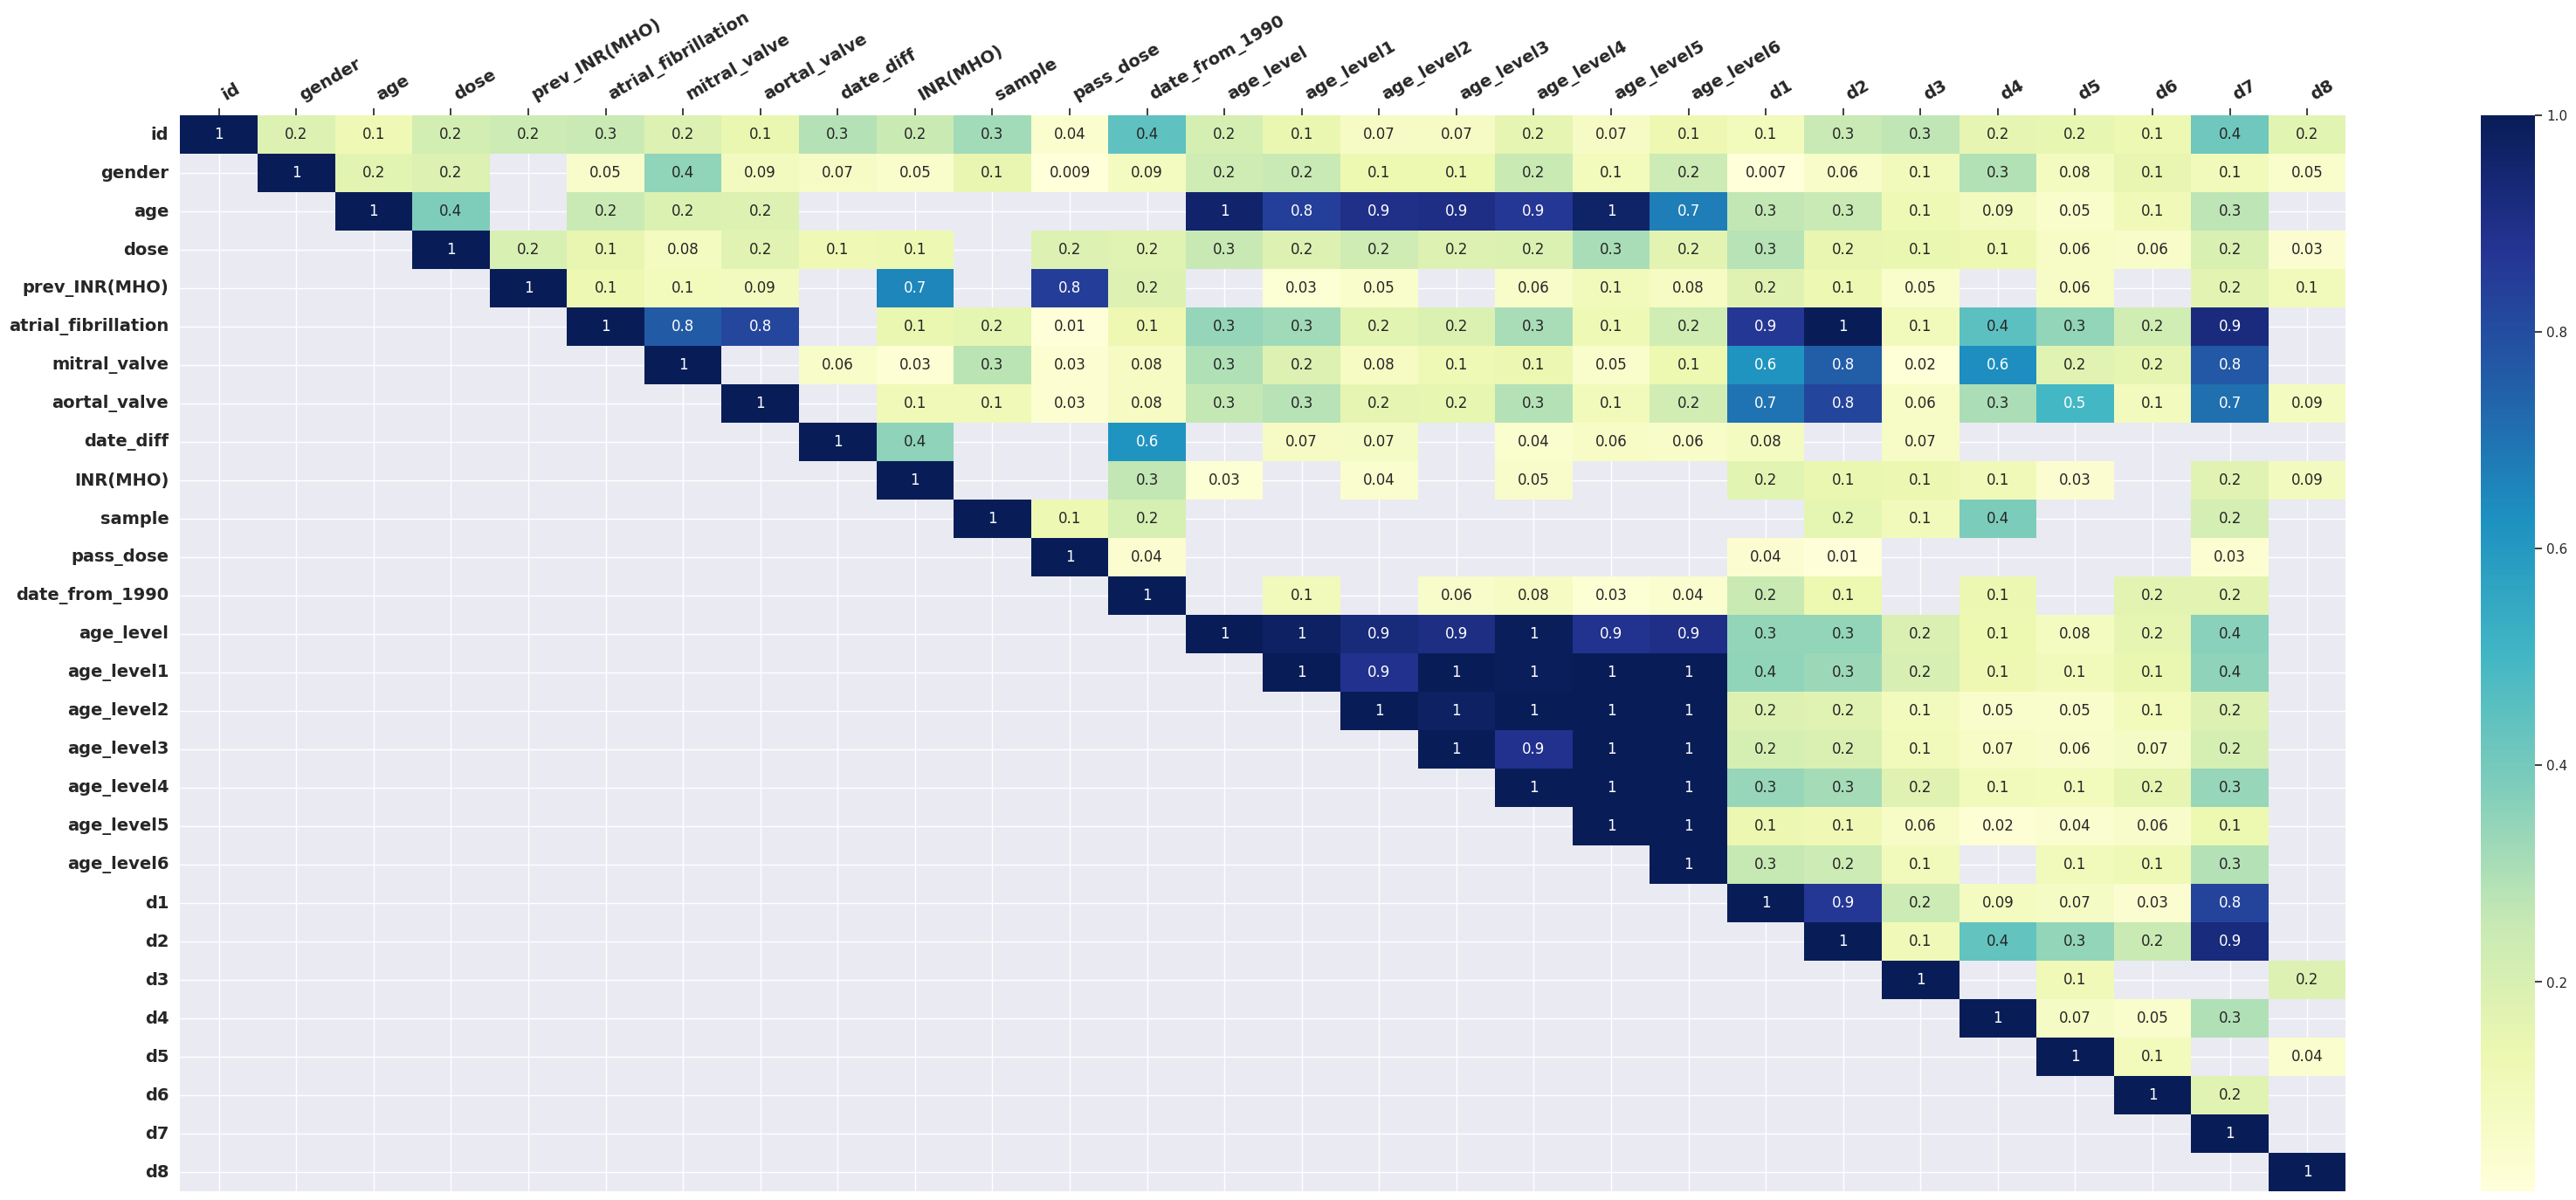

In [ ]:
# визуализация - тепловая карта phi_k
# вычисляем матрицу корреляций на основе коэффициента phik, который предназначен для вычисления корреляций
# между категориальными, порядковыми и интервальными переменными.
matrix = np.triu(data.phik_matrix())


# Установка параметров для будущего графика
sns.set(rc = {'figure.figsize':(40,16)})

# Визуализация тепловой карты
ax = sns.heatmap(
    matrix,
    annot=True,               # показать значения корреляции в ячейках
    cmap='YlGnBu',            # цвета от желтого через зеленый к синему
    fmt='.1g',                # один знак после запятой
    mask=matrix == 0,         # нули не показываем
    xticklabels=data.columns,  # показать названия колонок на оси x
    yticklabels=data.columns  # показать названия колонок на оси y
)

# Перемещение меток колонок наверх для удобства
ax.xaxis.tick_top()
# Поворот меток для лучшего отображения и установка размера шрифта
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='left', fontsize="14", weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), fontsize="14", weight="bold")

plt.show()


 Анализ корреляции показывает, что добавленные столбцы age_level, часть столбцов d1-d8 и статистические показатели по столбцу возраст  сильно коррелируют с показателями исходного датасета и между собой -  целесообразно рассмотреть их удаление. Но предварительно предлагается провести расчет релевантгности признаков с использованием других методов, которые реализованы в библиотеке sklearn и по результатам принять решение о чистке датасета.

# Определениe наиболее релевантных признаков в датасете с использованием методов автоматизированного отбора признаков.

In [ ]:
# Удаляем строки с пропущенными значениями
data = data.dropna()

# Подготовка данных
X = data.drop('dose', axis=1)
y = data['dose']

In [ ]:
from sklearn.feature_selection import RFE, f_classif, mutual_info_regression, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import MinMaxScaler

# 1. RFE (Recursive Feature Elimination)
# RFE рекурсивно уменьшает количество признаков, оценивая модель на каждом этапе и выбирая либо лучший, либо худший признак.
estimator = LinearRegression()
selector = RFE(estimator)
selector = selector.fit(X, y)
rfe_features = pd.Series(selector.support_, index=X.columns).apply(lambda x: 1 if x else 0)

# 2. RandomForest
# Случайный лес оценивает важность признаков на основе того, насколько часто каждый признак используется для принятия решений в деревьях.
model_rf = RandomForestRegressor()
model_rf.fit(X, y)
rf_importances = pd.Series(model_rf.feature_importances_, index=X.columns)

# 3. Lasso
# Lasso (линейная регрессия с L1-регуляризацией) может свести вес некоторых признаков к нулю, тем самым исключая их.
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X, y)
lasso_coefficients = pd.Series(model_lasso.coef_, index=X.columns)

# 4. SFS (Sequential Feature Selector)
# SFS последовательно добавляет или удаляет признаки на основе их производительности до достижения заданного числа признаков.
sfs = SFS(LinearRegression(),
          k_features='best',
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)
sfs.fit(X, y)
sfs_features = pd.Series([1 if i in list(sfs.k_feature_idx_) else 0 for i in range(X.shape[1])], index=X.columns)

# 5. ANOVA
# ANOVA (дисперсионный анализ) проверяет, имеют ли две или более группы схожие средние значения. В контексте отбора признаков это может помочь определить,
# влияет ли признак на целевую переменную.
f_scores, _ = f_classif(X, y)
f_features = pd.Series(f_scores, index=X.columns)

# 6. Mutual Information
# Взаимная информация измеряет зависимость между признаком и целевой переменной; ближе к 0 - меньше зависимости, ближе к 1 - более сильная зависимость.
mi_scores = mutual_info_regression(X, y)
mi_features = pd.Series(mi_scores, index=X.columns)

# 7. RFECV (Recursive Feature Elimination with Cross-Validation)
# RFECV сочетает RFE с кросс-валидацией, чтобы выбрать оптимальное количество признаков.
selector = RFECV(estimator)
selector = selector.fit(X, y)
rfecv_features = pd.Series(selector.support_, index=X.columns).apply(lambda x: 1 if x else 0)

# Сводная таблица
feature_table = pd.DataFrame({
    'RFE': rfe_features,
    'RandomForest': rf_importances,
    'Lasso': lasso_coefficients,
    'SFS': sfs_features,
    'Mutual Info': mi_features,
    'RFECV': rfecv_features
})

# Нормализация данных с весами
scaler = MinMaxScaler()
methods_with_weights = ['RandomForest', 'Lasso', 'Mutual Info']
feature_table[methods_with_weights] = scaler.fit_transform(feature_table[methods_with_weights])

# Расчет общей важности и создание рейтинга
feature_table['Total Importance'] = feature_table.sum(axis=1)
feature_ranking = feature_table.sort_values(by='Total Importance', ascending=False)

feature_ranking


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e+03, tolerance: 3.779e-01
  model = cd_fast.enet_coordinate_descent(


,RFE,RandomForest,Lasso,SFS,Mutual Info,RFECV,Total Importance
d1,1,0.383073,1.000000,1,0.053324,1,4.436396
INR(MHO),1,0.786680,0.363618,1,0.184464,0,3.334762
mitral_valve,1,0.095814,0.000000,1,0.000000,1,3.095814
date_from_1990,0,0.838238,0.276145,1,0.164267,0,2.278650
id,0,1.000000,0.273615,0,1.000000,0,2.273615
gender,1,0.170724,0.067011,1,0.015826,0,2.253561
d5,1,0.000000,0.067914,1,0.039764,0,2.107678
aortal_valve,1,0.148349,0.336628,0,0.149464,0,1.634442
age,0,0.906490,0.247677,0,0.443714,0,1.597880
d7,1,0.083092,0.367102,0,0.084243,0,1.534437


# Очистка датасета от лишних признаков(параметров)

In [ ]:
# на основании матрицы корреляции и автоматизированного отбора признаков можно предложить  показатели, которые можно удалить из датасета
# Предлагается удалить показатели из таблицы feature_ranking с рейтингом меньше 2, сохранив столбцы с начальными исходными данными из
# медицинских учереждений, такие как, например, age и date_diff

# Заданное значение рейтинга для удаления
rank = 2

# Признаки, которые нужно сохранить независимо от их рейтинга
vip_features = ['age', 'date_diff', 'aortal_valve','sample']

# Список признаков, которые нужно удалить
features_to_remove = feature_ranking[feature_ranking['Total Importance'] < rank].index.tolist()

# Исключение из этого списка важных признаков, которые оставляем
features_to_remove = [f for f in features_to_remove if f not in vip_features]

# Удаляем признаки из датасета
data = data.drop(columns=features_to_remove)


# Сохранение очищенного датасета

In [ ]:
data = data.dropna()
# сохраним результаты очищенного датасета в виртульное окружение - при необходимости сохраните на локальный диск вручную
data.to_excel('dataset_clear.xlsx', index=False)
#data.to_excel('dataset_clear.xlsx')

# Моделирование и оценка различных регрессоров. Высокая скорость работы.

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor



def augment_data_by_id(data, columns_to_augment, n_augmentations):

    """
    Аугментация данных на основе идентификаторов пациентов.

    Эта функция принимает на вход датафрейм, столбцы для аугментации и количество аугментаций (копий).
    Для каждого уникального идентификатора пациента в исходных данных создается n_augmentations копий
    с добавлением шума к значениям указанных столбцов. После аугментации присваивает каждому
    новому набору данных уникальный идентификатор пациента. Таким образом у нас появляются n_augmentations
    копий (в количестве исходных строк) каждого пациента с небольшим отличием в возрасте. Округлять возраст я не стал, но можно это добавить

    """

    augmented_data = data.copy()

    max_id = augmented_data['id'].max()
    for i in range(n_augmentations):

      augmented_data = data.copy()
      max_id = data['id'].max() + 1

      for _ in range(n_augmentations):
        temp_data = data.copy()

        for col in columns_to_augment:
            noise = np.random.normal(0, 0.5, size=temp_data.shape[0]) # np.random.normal генерирует случайные числа из нормального (гауссовского) распределения.
                                                                    # первый аргумент 0 означает, что в среднем шум будет равен 0.
                                                                    # 0.5 - большинство шумовых значений будут в диапазоне от -0.5 до 0.5
                                                                    # size -количество случайных чисел (в данном случае количество строк в датасете)
            for patient_id in data['id'].unique():  # Для каждого уникального ID пациента
                mask = (temp_data['id'] == patient_id) # маска для текущего ID пациента
                temp_data.loc[mask, col] = temp_data.loc[mask, col] + noise[mask] # Добавляем шум к значениям указанного столбца, соответствующим текущему ID пациента

        temp_data['id'] = temp_data['id'] + max_id
        max_id += data['id'].max() + 1
        augmented_data = pd.concat([augmented_data, temp_data], axis=0)


    return augmented_data


def train_regressors(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    regressors = {
        'XGBoost': xgb.XGBRegressor(objective ='reg:squarederror'),
        'Gradient Boosting': GradientBoostingRegressor(),
        'Random Forest': RandomForestRegressor(),
        'KNeighbors': KNeighborsRegressor(),
        'Linear Regression': LinearRegression(),
        'LightGBM': LGBMRegressor(),
        'CatBoost': CatBoostRegressor(verbose=0)
    }

    predictions_test = {}
    predictions_train = {}

    for name, regressor in regressors.items():
        regressor.fit(X_train, y_train)
        predictions_test[name] = regressor.predict(X_test)
        predictions_train[name] = regressor.predict(X_train)

    return y_train, y_test, predictions_train, predictions_test


def compute_metrics(y_true, predictions):
    results = {}

    for name, y_pred in predictions.items():
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = (abs((y_true - y_pred) / y_true).mean()) * 100
        mae = mean_absolute_error(y_true, y_pred)
        percent_deviation = (abs((y_true - y_pred) / y_true.mean()) * 100).mean()

        results[name] = [mse, r2, mape, mae, percent_deviation]

    return pd.DataFrame(results, index=['Mean Squared Error', 'R^2', 'MAPE', 'MAE', 'Average Percent Deviation']).T

from tabulate import tabulate

def display_results(y_train, y_test, predictions_train, predictions_test):
    metrics_train = compute_metrics(y_train, predictions_train)
    metrics_test = compute_metrics(y_test, predictions_test)

    print("===== Метрики на обучающих данных =====")
    print(tabulate(metrics_train, headers='keys', tablefmt='grid'))

    print("\n===== Метрики на тестовых данных =====")
    print(tabulate(metrics_test, headers='keys', tablefmt='grid'))



In [ ]:
#  Подготовка данных. Загрузка оригинального датасета.
df = pd.read_excel('/content/dataset_clear.xlsx')
df_cleaned = df.dropna()
X = df_cleaned.drop('dose', axis=1)
y = df_cleaned['dose']

# запускаем  обучение, расчет и вывод метрик
y_train, y_test, predictions_train, predictions_test = train_regressors(X, y)
display_results(y_train, y_test, predictions_train, predictions_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 885
[LightGBM] [Info] Number of data points in the train set: 1173, number of used features: 11
[LightGBM] [Info] Start training from score 3.603154
===== Метрики на обучающих данных =====
+-------------------+----------------------+----------+----------+----------+-----------------------------+
|                   |   Mean Squared Error |      R^2 |     MAPE |      MAE |   Average Percent Deviation |
+===================+======================+==========+==========+==========+=============================+
| XGBoost           |            0.0328365 | 0.987138 |  4.11251 | 0.122653 |                     3.40404 |
+-------------------+----------------------+----------+----------+----------+-----------------------------+
| Gradient Bo

In [ ]:
# Аугментируем данные добавляя n_augmentations копий каждого пациента с добавлением шума в возраст
combined_data = augment_data_by_id(data, ['age'], n_augmentations=5)

X = combined_data.drop('dose', axis=1)
y = combined_data['dose']
#print(X)




In [ ]:
# запускаем  обучение, расчет и вывод метрик
y_train, y_test, predictions_train, predictions_test = train_regressors(X, y)
display_results(y_train, y_test, predictions_train, predictions_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 7041, number of used features: 11
[LightGBM] [Info] Start training from score 3.620828
===== Метрики на обучающих данных =====
+-------------------+----------------------+----------+----------+-----------+-----------------------------+
|                   |   Mean Squared Error |      R^2 |     MAPE |       MAE |   Average Percent Deviation |
+===================+======================+==========+==========+===========+=============================+
| XGBoost           |           0.108388   | 0.958543 |  8.07982 | 0.235501  |                     6.50406 |
+-------------------+----------------------+----------+----------+-----------+-----------------------------+
| Gradient Boosting |           1.65716    | 0.366155 | 37.7053  | 1.01